# Main analysis

This is the main analysis of the Cognate Priming experiment. We fit a series of incrementally more complex models on the processed data (see R folder). The aim of this analysis is to test:

* If fixations to the target object grow slowlier across conditions (`condition`: cognate vs. non-cognate vs. unrelated trials)
* If the effect of condition is mediated by the language background of participants (`group`: monolinguals vs. bilinguals)
* How (and if) these effects change accross three age points (`age`: 21, 25 and 30 months)

We will adjust our estimates to the vocabulary size (`vocabulary`: composite score of comprehensive and productive vocabulary size), and lexical frequency of the target (`frequency`, Zipf score as extracted from SUBTLEX). To account for repeated measures, we will add by-participant and by-trial random intercepts and slopes when necessary. Numeric predictors will be standardized and categorical predictors will be effect-coded (-0.5, 0.5).

Formally, this is the extended model (`fit4`) we are fitting. We will compare its fit against that of simpler models:

* `fit0`: includes an intercept
* `fit1`: adds `vocabulary` and `frequency` main effects to `fit0`
* `fit2`: adds `age` main effect to `fit1`
* `fit3`: adds `group` main effect, the `age*group` interaction to `fit2`

All `fit0`, `fit1`, `fit2`, and `fit3` will include participants-level and trial-level adjustments where necessary. Equation (\ref{eq1}) shows the formula of `fit4`, the extended model.

$
\begin{equation}\label{eqn:eq1}\tag{1}
\begin{split}
\begin{aligned}
y {}={} & (\beta_{0}+P_{i0}+T_{j0}) + \dots \\
& (\beta_{1}+P_{i1}+T_{j1}) \times Condition + \dots \\
& (\beta_{2}+T_{j2}) \times  Group + \dots \\
& (\beta_{3}+P_{i1}+T_{j1}) \times Age + \dots \\
& \beta_{4} \times Vocabulary + \dots \\
& \beta_{5} \times Frequency + \dots \\
& (\beta_{6}+T_{j6}) \times (Condition \times Group) + \dots \\
& (\beta_{7}+P_{i7}+T_{j7}) \times (Condition \times Age) + \dots \\
& (\beta_{8}+T_{j8}) \times (Group \times Age) + \dots \\
& (\beta_{9}+T_{j9}) \times (Condition \times Group \times Age) + \epsilon, \\
& \epsilon \sim \mathcal{N}(0, 1)\\ \\
Where: \\
 i &= \text{participant index} \\
 j &= \text{trial index} \\
 \beta_{k} &= \text{coefficient of fixed population level effect}\\
 P_{ik} &= \text{participant-level adjustment for \beta_{k}} \\
 T_{jk} &= \text{trial-level adjustment for \beta_{k}} \\
 \epsilon &= \text{model residual error}
\end{aligned}
\end{split}
\end{equation}
$

## Set up
Define parameters and load packages. Running this cell may take a couple of minutes because packages are recomplied when loaded.

In [158]:
using CSV
using DataFrames
using DataFramesMeta
using Statistics
using StatsBase
using StatsModels
using MixedModels
using Plots

## Import and process data

In [188]:
colnames = ["participant", "age", "group", "trial", "condition", "time", "target", "fixation", "n"]
raw = CSV.read(
    "../Results/gaze_time_bins.csv",
    DataFrame,
    missingstrings = ["NA"],
    datarow = 2,
    header = colnames
) 
first(raw, 10)

,participant,age,group,trial,condition,time,target,fixation
,String,Int64,String,Int64,String?,Int64,String?,Int64
1,cognatepriming18,30,Bilingual,1,Cognate,1,boca,0
2,cognatepriming18,30,Bilingual,1,Cognate,2,boca,0
3,cognatepriming18,30,Bilingual,1,Cognate,3,boca,0
4,cognatepriming18,30,Bilingual,1,Cognate,4,boca,0
5,cognatepriming18,30,Bilingual,1,Cognate,5,boca,0
6,cognatepriming18,30,Bilingual,1,Cognate,6,boca,0
7,cognatepriming18,30,Bilingual,1,Cognate,7,boca,0
8,cognatepriming18,30,Bilingual,1,Cognate,8,boca,0
9,cognatepriming18,30,Bilingual,1,Cognate,9,boca,0


Recode variables (`age`, `group` and `condition` should be categorical) and calculate the empirical logit of target fixations using formula (\ref{logit}, Barr 2008). This transformation allows us to compute the probability of target fixation within each time bin while accounting for the bounded range {0, 1} of this variable in our models.

$
\begin{equation} \tag{2}
elogit(y) = \frac{log(y + 1/2)}{N-y + 1/2}
\end{equation}
$

In [191]:
logit(y, n) = @. log(y .+ 0.5) ./ (n-y .+ 0.5)
# recode variables
d = @linq raw |>
    where(:time .<= 20) |>
    groupby([:participant, :trial, :target, :condition, :group])
d = combine(
    d,
    :fixation => sum,
    :n => sum
)
d.logit = logit(d1.fixation_sum, d1.n_sum)
d.condition = categorical(d.condition)
d.group = categorical(d.group)
d = dropmissing(d)
describe(d)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,participant,,cognatepriming18,,cognatepriming82,0
2,trial,16.4849,1,16.0,32,0
3,target,,abella,,zanahoria,0
4,condition,,Cognate,,Unrelated,0
5,group,,Bilingual,,Monolingual,0
6,fixation_sum,94.0324,0,98.0,241,0
7,n_sum,239.708,209,240.0,241,0
8,logit,0.0784703,-0.00310133,0.0321393,10.9737,0


## Fit models

In [192]:
# define formulas
f0 = @formula logit ~ 1 + (1 | participant) + (1 | target)
f1 = @formula logit ~ group + (1 | participant) + (1 + group | target)
f2 = @formula logit ~ group * condition + (1 + condition | participant) + (1 + condition | target)

FormulaTerm
Response:
  logit(unknown)
Predictors:
  group(unknown)
  condition(unknown)
  (condition,participant)->(1 + condition) | participant
  (condition,target)->(1 + condition) | target
  group(unknown) & condition(unknown)

In [193]:
# define contrasts
group_contr = Matrix([-1/2 1/2]')
condition_contr = Matrix([1/3 1/3 -1/3; 1/3 -1/3 0]')
contr = Dict(
    :group => StatsModels.ContrastsCoding(group_contr, levels = ["Monolingual", "Bilingual"]),
    :condition => StatsModels.ContrastsCoding(condition_contr, levels = ["Cognate", "Non-cognate", "Unrelated"]),
)

Dict{Symbol,ContrastsCoding{Array{Float64,2}}} with 2 entries:
  :group     => ContrastsCoding{Array{Float64,2}}([-0.5; 0.5], ["Monolingual", …
  :condition => ContrastsCoding{Array{Float64,2}}([0.333333 0.333333; 0.333333 …

### Fit models

In [194]:
m0 = fit(MixedModel, f0, d, REML = false)

Linear mixed model fit by maximum likelihood
 logit ~ 1 + (1 | participant) + (1 | target)
   logLik   -2 logLik     AIC       AICc        BIC    
 -1773.2267  3546.4535  3554.4535  3554.4751  3576.5452

Variance components:
               Column    Variance  Std.Dev. 
target      (Intercept)  0.0000000 0.0000000
participant (Intercept)  0.0008434 0.0290414
Residual                 0.3973535 0.6303598
 Number of obs: 1850; levels of grouping factors: 61, 59

  Fixed-effects parameters:
──────────────────────────────────────────────────
                 Coef.  Std. Error     z  Pr(>|z|)
──────────────────────────────────────────────────
(Intercept)  0.0784553   0.0151432  5.18     <1e-6
──────────────────────────────────────────────────

In [195]:
m1 = fit(MixedModel, f1, d, REML = false, contrasts = contr)

Linear mixed model fit by maximum likelihood
 logit ~ 1 + group + (1 | participant) + (1 + group | target)
   logLik   -2 logLik     AIC       AICc        BIC    
 -1770.6394  3541.2788  3555.2788  3555.3396  3593.9393

Variance components:
                 Column       Variance  Std.Dev.   Corr.
target      (Intercept)       0.0015379 0.0392160
            group: Bilingual  0.0069101 0.0831269 -1.00
participant (Intercept)       0.0004276 0.0206775
Residual                      0.3932846 0.6271241
 Number of obs: 1850; levels of grouping factors: 61, 59

  Fixed-effects parameters:
─────────────────────────────────────────────────────────
                       Coef.  Std. Error      z  Pr(>|z|)
─────────────────────────────────────────────────────────
(Intercept)        0.0734121   0.0159031   4.62    <1e-5
group: Bilingual  -0.0501084   0.0320064  -1.57    0.1174
─────────────────────────────────────────────────────────

In [196]:
m2 = fit(MixedModel, f2, d, REML = false, contrasts = contr)

Linear mixed model fit by maximum likelihood
 logit ~ 1 + group + condition + group & condition + (1 + condition | participant) + (1 + condition | target)
   logLik   -2 logLik     AIC       AICc        BIC    
 -1764.4591  3528.9181  3566.9181  3567.3334  3671.8540

Variance components:
                    Column          Variance  Std.Dev.   Corr.
target      (Intercept)             0.0017575 0.0419226
            condition: Non-cognate  0.0279916 0.1673070 -0.42
            condition: Unrelated    0.0263799 0.1624188 +0.31 +0.73
participant (Intercept)             0.0000000 0.0000000
            condition: Non-cognate  0.0406432 0.2016016   NaN
            condition: Unrelated    0.0579646 0.2407584   NaN +1.00
Residual                            0.3829266 0.6188107
 Number of obs: 1850; levels of grouping factors: 61, 59

  Fixed-effects parameters:
────────────────────────────────────────────────────────────────────────────────────
                                                 

## Compare models

In [197]:
const mods = [m0, m1, m2];

gofsumry = DataFrame(
    dof = dof.(mods),
    deviance = deviance.(mods),
    AIC = aic.(mods),
    AICc = aicc.(mods),
    BIC = bic.(mods)
)

,dof,deviance,AIC,AICc,BIC
,Int64,Float64,Float64,Float64,Float64
1,4,3546.45,3554.45,3554.48,3576.55
2,7,3541.28,3555.28,3555.34,3593.94
3,19,3528.92,3566.92,3567.33,3671.85


## Diagnostics

In [198]:
VarCorr(m2)

Variance components:
                    Column          Variance  Std.Dev.   Corr.
target      (Intercept)             0.0017575 0.0419226
            condition: Non-cognate  0.0279916 0.1673070 -0.42
            condition: Unrelated    0.0263799 0.1624188 +0.31 +0.73
participant (Intercept)             0.0000000 0.0000000
            condition: Non-cognate  0.0406432 0.2016016   NaN
            condition: Unrelated    0.0579646 0.2407584   NaN +1.00
Residual                            0.3829266 0.6188107


In [199]:
DataFrame(m2.rePCA)

,target,participant
,Float64,Float64
1,0.579164,1.0
2,1.0,1.0
3,1.0,1.0


In [210]:
logitprob(x) = exp.(x) ./ (1 + exp.(x))

d.logit_pred = predict(m2)
d.prob = logitprob.(d.logit)
d.prod_pred = logitprob.(d.logit_pred)
describe(d)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,participant,,cognatepriming18,,cognatepriming82,0
2,trial,16.4849,1,16.0,32,0
3,target,,abella,,zanahoria,0
4,condition,,Cognate,,Unrelated,0
5,group,,Bilingual,,Monolingual,0
6,fixation_sum,94.0324,0,98.0,241,0
7,n_sum,239.708,209,240.0,241,0
8,logit,0.0784703,-0.00310133,0.0321393,10.9737,0
9,logit_pred,0.0784703,-0.138991,0.051663,0.845005,0


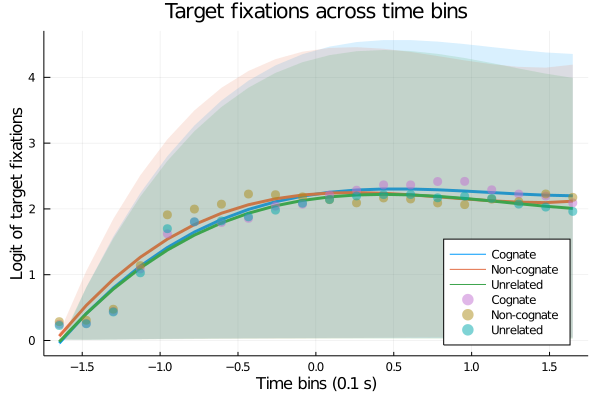

In [228]:
gr()
plot(
    d.condition, d.logit_pred_mean,
    group = preds.condition,
    linewidth=3, 
    ribbon = (
        preds.logit_pred_mean .- preds.logit_pred_sem,
        preds.logit_pred_mean .- preds.logit_pred_sem
    ),
    fillalpha = 0.15
)
plot!(
    d_preds.time1, d_preds.logit_mean,
    group = d_preds.condition,
    seriestype = :scatter,
    ms = 5,
    markerstrokewidth = 0,
    malpha = 0.5
)
plot!(
    title = "Target fixations across time bins",
    xguide = "Time bins (0.1 s)",
    yguide = "Logit of target fixations",
    legend=:bottomright
)


